Estimated pH: 7.50


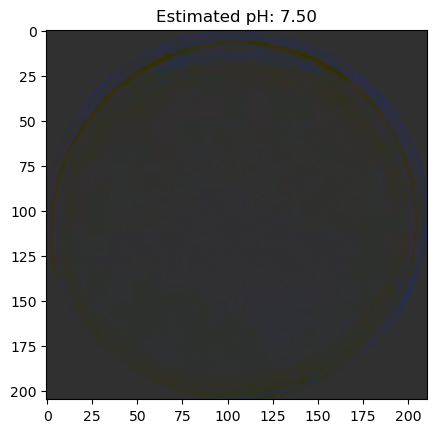

In [68]:
import cv2
import numpy as np
from scipy.spatial import distance
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def apply_gray_world(image):
    """Коррекция баланса белого с использованием алгоритма серого мира."""
    avg_rgb = np.mean(image, axis=(0, 1))
    gray_world_img = np.divide(image, avg_rgb) * np.mean(avg_rgb)
    np.clip(gray_world_img, 0, 255, out=gray_world_img)
    return gray_world_img.astype(np.uint8)

def apply_clahe(image):
    """Улучшение контраста с использованием CLAHE."""
    lab_img = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])
    return cv2.cvtColor(lab_img, cv2.COLOR_Lab2BGR)

def normalize_l_component(image):
    """Нормализация L-компоненты в пространстве LAB."""
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab_image)
    l.fill(50)
    return cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_Lab2BGR)

def get_mean_ab_color(image):
    """Получение средних значений компонент a и b в пространстве LAB."""
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    return np.mean(lab_image[:, :, 1]), np.mean(lab_image[:, :, 2])

# Загрузка изображения
image_path = 'image/6.0A.png'  # Укажите путь к изображению
image = cv2.imread(image_path)

# Предварительная обработка и нормализация изображения
image_corrected = apply_gray_world(image)
image_contrasted = apply_clahe(image_corrected)
normalized_image = normalize_l_component(image_contrasted)

# Вычисление средних значений a и b
mean_a, mean_b = get_mean_ab_color(normalized_image)

# Словарь эталонных значений pH и соответствующих им цветов в LAB (только a и b компоненты)
reference_values = {
    (235, 223): 8.0,
    (232, 217): 7.7,
    (220, 119): 7.5,
    (225, 126): 7.2,
    (228, 234): 6.9,
    (236, 127): 6.5,
    (220, 235): 6.3,
    (207, 234): 6.0,
    (174, 234): 5.7,
}

# Подготовка данных для интерполяции
ab_points = np.array(list(reference_values.keys()))
ph_values = np.array(list(reference_values.values()))

# Интерполяция для оценки pH
estimated_ph = griddata(ab_points, ph_values, [(mean_a, mean_b)], method='nearest')[0]

print(f'Estimated pH: {estimated_ph:.2f}')

# Визуализация обработанного изображения
plt.imshow(cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB))
plt.title(f'Estimated pH: {estimated_ph:.2f}')
plt.show()


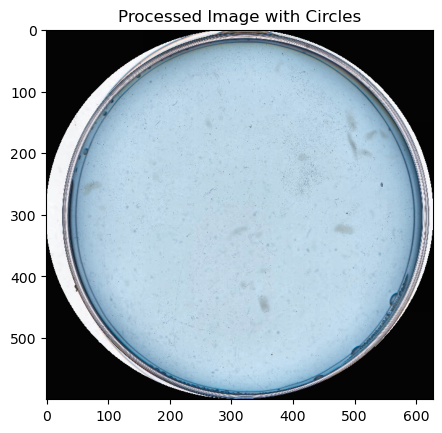

In [71]:
import cv2
import numpy as np
from scipy.spatial import distance
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def apply_clahe(image):
    """Улучшение контраста с использованием CLAHE."""
    lab_img = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])
    return cv2.cvtColor(lab_img, cv2.COLOR_Lab2BGR)

def find_circles(image):
    """Обнаружение кругов на изображении."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=20, maxRadius=200)
    if circles is not None:
        circles = np.uint16(np.around(circles))
    return circles

def get_center_circle_mask(image, circle):
    """Создание маски для центральной части круга."""
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.circle(mask, (circle[0], circle[1]), circle[2] // 2, 255, -1)  # Используем радиус в половину от обнаруженного
    return mask

# Загрузка и предварительная обработка изображения
image_path = 'image/7.7.png'  # Укажите путь к изображению
image = cv2.imread(image_path)
image_contrasted = apply_clahe(image)

# Обнаружение кругов
circles = find_circles(image_contrasted)

if circles is not None:
    for circle in circles[0, :]:
        x, y, r = circle
        mask = get_center_circle_mask(image_contrasted, circle)
        # Выделение центральной части круга и получение средних значений цвета
        mean_color = cv2.mean(image_contrasted, mask=mask)[:3]
        lab_image = cv2.cvtColor(np.uint8([[mean_color]]), cv2.COLOR_BGR2Lab)[0][0]
        mean_a, mean_b = lab_image[1], lab_image[2]

        # Здесь можно добавить код для оценки pH, используя mean_a и mean_b

# Визуализация обработанного изображения с выделенным кругом
plt.imshow(cv2.cvtColor(image_contrasted, cv2.COLOR_BGR2RGB))
if circles is not None:
    for circle in circles[0, :]:
        cv2.circle(image_contrasted, (circle[0], circle[1]), circle[2], (0, 255, 0), 4)
plt.title('Processed Image with Circles')
plt.show()


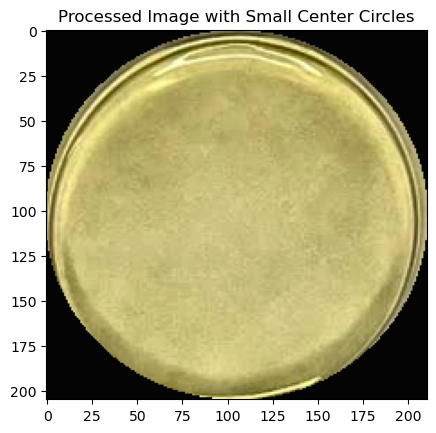

In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_clahe(image):
    """Улучшение контраста с использованием CLAHE."""
    lab_img = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])
    return cv2.cvtColor(lab_img, cv2.COLOR_Lab2BGR)

def find_circles(image):
    """Обнаружение кругов на изображении."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=20, maxRadius=200)
    if circles is not None:
        circles = np.uint16(np.around(circles))
    return circles

def get_small_center_circle_mask(image, circle):
    """Создание маски для маленького кружка в центре круга."""
    mask = np.zeros(image.shape[:2], dtype="uint8")
    # Для маленького кружка используем радиус, который составляет 25% от обнаруженного радиуса круга
    cv2.circle(mask, (circle[0], circle[1]), circle[2] // 4, 255, -1)
    return mask

# Загрузка и предварительная обработка изображения
image_path = 'image/6.0A.png'  # Укажите путь к изображению
image = cv2.imread(image_path)
image_contrasted = apply_clahe(image)

# Обнаружение кругов
circles = find_circles(image_contrasted)

if circles is not None:
    for circle in circles[0, :]:
        x, y, r = circle
        mask = get_small_center_circle_mask(image_contrasted, circle)
        # Выделение маленького кружка в центре и получение средних значений цвета
        mean_color = cv2.mean(image_contrasted, mask=mask)[:3]
        # Дальнейшая обработка...
        # Например, можно преобразовать mean_color в LAB и использовать для анализа

# Визуализация
plt.imshow(cv2.cvtColor(image_contrasted, cv2.COLOR_BGR2RGB))
if circles is not None:
    for circle in circles[0, :]:
        # Отрисовка маленького кружка в центре большого круга
        cv2.circle(image_contrasted, (circle[0], circle[1]), circle[2] // 4, (0, 255, 0), 2)
plt.title('Processed Image with Small Center Circles')
plt.show()


Estimated pH for circle at (157, 160): 7.50


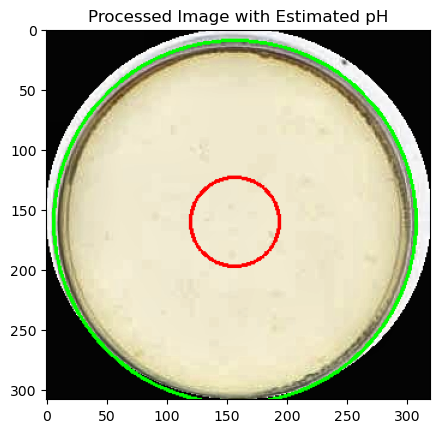

In [79]:
import cv2
import numpy as np
from scipy.spatial import distance
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def apply_clahe(image):
    """Улучшение контраста с использованием CLAHE."""
    lab_img = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])
    return cv2.cvtColor(lab_img, cv2.COLOR_Lab2BGR)

def find_circles(image):
    """Обнаружение кругов на изображении."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=20, maxRadius=200)
    if circles is not None:
        circles = np.uint16(np.around(circles))
    return circles

def get_small_center_circle_mask(image, circle):
    """Создание маски для маленького кружка в центре круга."""
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.circle(mask, (circle[0], circle[1]), max(circle[2] // 4, 1), 255, -1)
    return mask

def estimate_pH(lab_color, reference_values):
    """Оценка pH на основе среднего цвета и эталонных значений."""
    ab_points = np.array([key for key in reference_values.keys()])
    ph_values = np.array(list(reference_values.values()))
    estimated_ph = griddata(ab_points, ph_values, [lab_color[1:]], method='nearest')[0]
    return estimated_ph

# Загрузка и предварительная обработка изображения
image_path = 'image/6.0.png'  # Замените на путь к вашему изображению
image = cv2.imread(image_path)
image_contrasted = apply_clahe(image)

# Обнаружение кругов
circles = find_circles(image_contrasted)

# Словарь эталонных значений pH
reference_values = {
    (235, 223): 8.0,
    (232, 217): 7.7,
    (220, 119): 7.5,
    (225, 126): 7.2,
    (228, 234): 6.9,
    (236, 127): 6.5,
    (220, 235): 6.3,
    (207, 234): 6.0,
    (174, 234): 5.7,
}

if circles is not None:
    for circle in circles[0, :]:
        mask = get_small_center_circle_mask(image_contrasted, circle)
        mean_color = cv2.mean(image_contrasted, mask=mask)[:3]
        lab_image = cv2.cvtColor(np.uint8([[mean_color]]), cv2.COLOR_BGR2Lab)[0][0]
        estimated_ph = estimate_pH(lab_image, reference_values)
        print(f"Estimated pH for circle at ({circle[0]}, {circle[1]}): {estimated_ph:.2f}")

        # Визуализация
        cv2.circle(image_contrasted, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
        cv2.circle(image_contrasted, (circle[0], circle[1]), max(circle[2] // 4, 1), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(image_contrasted, cv2.COLOR_BGR2RGB))
plt.title('Processed Image with Estimated pH')
plt.show()
